# Convolution based time series classification in aeon

This notebook is a high level introduction to using and configuring convolution based
classifiers in aeon. Convolution based classifiers are based on the ROCKET transform
[1] and the subsequent extensions MiniROCKET [2] and MultiROCKET [3]. These
transforms can be used in pipelines, but we provide two convolution based classifiers
 based on ROCKET for ease of use and reproducability. The RocketClassifier combines
 the transform with  a scikitlearn RidgeClassifierCV classifier.  Ther term
 convolution and kernel are  used interchangably in this notebook. A convolution is a
  subseries that is used to create features for a time series. To do this, a
  convolution is run along a series, and the dot product is calculated. The creates a
   new series (often called an activation map or feature map) where large values
   correspond to a close correlation to the convolution.

<img src="./img/convolution.png" width="600" alt="Windowing.">

ROCKET computes two features from the resulting feature maps: the maximum value
(sometimes called a max pooling operation), and the proportion of positive values (or
 ppv). In the above example the first entry of the activation map is the result of a
 dot-product between $T_{1:3} * \omega = T_{1:3} \cdot \omega = 0 + 0 + 3 = 3$. Max
 pooling extracts the maximum from the activation map as feature. The proportion of
 positive values (PPV) is $8 / 11$ in this example.

A large number of random convolutions are generated, and the two features are
combined to produce a transformed train data set. This is used to train a linear
classifier. [1] reccomend a RIDGE Regression Classifier using cross-validation to
train the $L_2$-regularisation parameter $\alpha$. A logistic regression classifier
is suggested as a replacement for larger datasets.
<img src="./img/rocket2.png" width="600" alt="ROCKET.">

ROCKET employs dilation. Dilation is a form of down sampling, in that it defines
spaces between time points. Hence, a convolution with dilation $d$ is compared to
time points $d$ steps apart when calculating the distance.


In [1]:
import warnings

from aeon.registry import all_estimators

warnings.filterwarnings("ignore")
all_estimators(
    "classifier", filter_tags={"algorithm_type": "convolution"}, as_dataframe=True
)

[('Arsenal', aeon.classification.convolution_based._arsenal.Arsenal),
 ('RocketClassifier',
  aeon.classification.convolution_based._rocket_classifier.RocketClassifier)]

In [2]:
from sklearn.metrics import accuracy_score

from aeon.classification.convolution_based import Arsenal, RocketClassifier
from aeon.datasets import load_basic_motions  # multivariate dataset
from aeon.datasets import load_italy_power_demand  # univariate dataset

italy, italy_labels = load_italy_power_demand(split="train")
italy_test, italy_test_labels = load_italy_power_demand(split="test")
motions, motions_labels = load_basic_motions(split="train")
motions_test, motions_test_labels = load_basic_motions(split="train")
italy.shape

(67, 1, 24)

ROCKET compiles (via Numba) on import, which may take a few seconds. ROCKET does not
produce estimates of class probabilities. Because of this, the Arsenal was developed
to use with the HIVE-COTE meta-ensemble (in the hybrid package). The Arsenal is an
ensemble of ROCKET classifiers that is no more accurate than ROCKET, but gives better
 probability estimates.

<img src="./img/rocket.png" width="600" alt="Rocket overview.">


In [3]:
rocket = RocketClassifier()
rocket.fit(italy, italy_labels)
y_pred = rocket.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.967930029154519

In [4]:
afc = Arsenal()
afc.fit(italy, italy_labels)
y_pred = afc.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.9698736637512148

MiniROCKET[2]  is a fast version of ROCKET that uses hard coded convolutions and only
 uses PPV. MultiROCKET [3] adds three new pooling operations extracted from each
 kernel: mean of positive values (MPV), mean of indices of positive values (MIPV) and
  longest stretch of positive values (LSPV). MultiRocket generates a total of 50k
  features from 10k kernels and 5 pooling operations. It also extracts features from
  first order differences. The RocketClassifier and Arsenal can be configured to use
  MiniROCKET and MultiROCKET. Simply set with rocket_transform as "minirocket" or
  "multirocket". Both work on multivariate series: channels are simply randomly
  selected for each convolution.

In [5]:
multi_r = Arsenal(rocket_transform="multirocket")
multi_r.fit(italy, italy_labels)
y_pred = multi_r.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.9718172983479106

In [6]:
mini_r = RocketClassifier(rocket_transform="minirocket")
mini_r.fit(motions, motions_labels)
y_pred = mini_r.predict(motions_test)
accuracy_score(motions_test_labels, y_pred)

1.0

RocketClassifier has three other parameters that may effect performance.
`num_kernels` (default 10,000) determines the number of convolutions/kernels generated
 and will influence the memory usage. `max_dilations_per_kernel` (default=32) and
`n_features_per_kernel` (default=4) are used in 'MiniROCKET' and 'MultiROCKET. For
each candidate convolution, `max_dilations_per_kernel` are assessed and
`n_features_per_kernel` are retained.


## Performance on the UCR univariate datasets

You can find the convolution based classifiers as follows

In [1]:
from aeon.registry import all_estimators

convo = all_estimators("classifier", filter_tags={"algorithm_type": "convolution"})
for c in convo:
    print(c)

('Arsenal', <class 'aeon.classification.convolution_based._arsenal.Arsenal'>)
('HydraClassifier', <class 'aeon.classification.convolution_based._hydra.HydraClassifier'>)
('MultiRocketHydraClassifier', <class 'aeon.classification.convolution_based._mr_hydra.MultiRocketHydraClassifier'>)
('RocketClassifier', <class 'aeon.classification.convolution_based._rocket_classifier.RocketClassifier'>)


We can recover the results and compare the classifier performance as follows:


In [2]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_data_lists import univariate

names = [t[0] for t in convo]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 4)

(<Figure size 600x230 with 1 Axes>, <Axes: >)

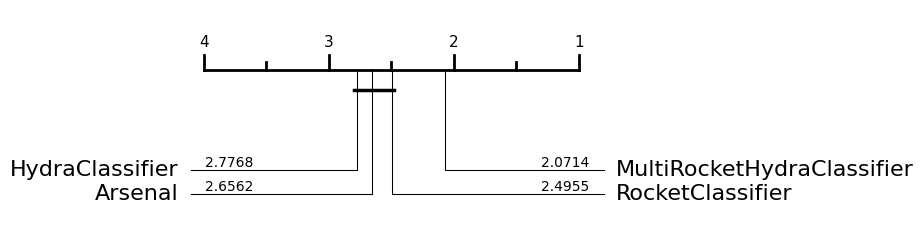

In [3]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

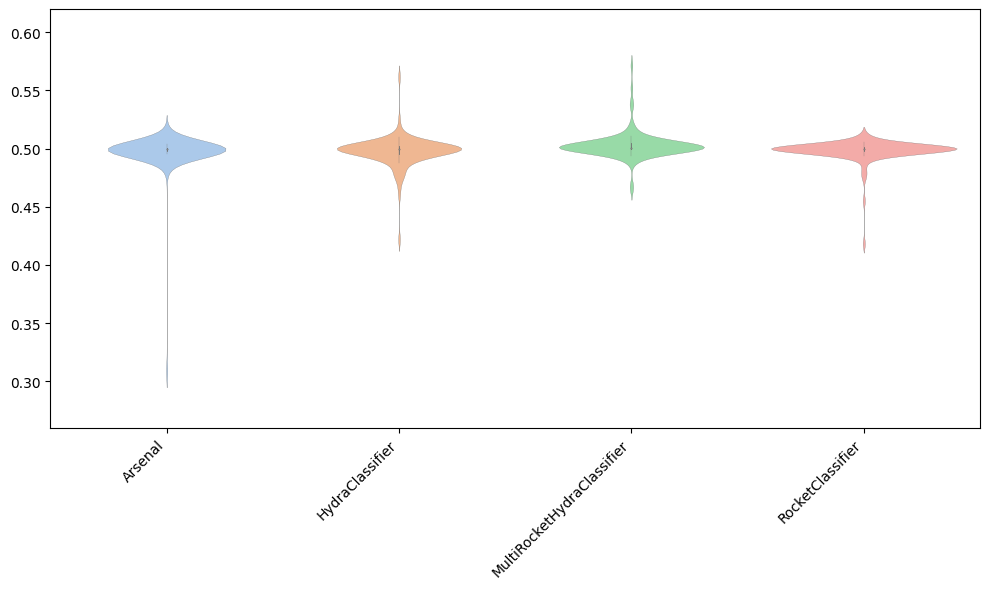

In [4]:
plot_boxplot_median(results, names)

## References

[1] Dempster A, Petitjean F and Webb GI (2019) ROCKET: Exceptionally fast
and accurate time series classification using random convolutional kernels.
[arXiv:1910.13051] (https://arxiv.org/abs/1910.13051),
[Journal Paper](https://link.springer.com/article/10.1007/s10618-020-00701-z)

[2]  Dempster A, Schmidt D and Webb G (2021) MINIROCKET: A Very Fast (Almost)
Deterministic Transform for Time Series Classification
[arXiv:2012.08791](https://arxiv.org/abs/2012.08791)
[Conference Paper](https://dl.acm.org/doi/abs/10.1145/3447548.3467231)

[3] Cahng Wei T, Dempster A, Bergmeir C and Webb G (2022) MultiRocket: multiple pooling
operators and transformations for fast and effective time series classification
[Journal Paper](https://link.springer.com/article/10.1007/s10618-022-00844-1)
